## 1) Daten aus CSV-Datei auslesen

In [3]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import os
import csv
import tensorflow as tf

########## Input ##########

fits_path = 'F:\\data\\spectral_fits'
samples_per_class = 1000

########## Program ##########

# Listen mit den flux Werten, Labels und Wellenlängen erstellen
data = np.load(fit_path + "data.npy")
labels = np.load(fit_path + "labels.npy")
wavelengths = np.load(fit_path + "wavelengths.npy")

# Liste die Galaxie-Nummer speichert
numbers = range(4*samples_per_class)

In [4]:
# TEST: WIEDER LÖSCHEN -> keine Verbesserung
# negative Werte werden auf 0.1 gesetzt

# for i in range(len(data)):
#     for t in range(len(data[i])):
#         if data[i][t] <= 0.1:
#             data[i][t] = 0.1

## 2) Normierung

In [1]:
median_limit = 3
data_normalized = np.zeros(shape=(4000,3522))

# Normierungs-Test: median normalization
for i in range(len(data)):
    
    # median normalization
    sorted = np.sort(data[i])
    median = 0.5* (data[i][1760] + data[i][1761])
    data_normalized[i] = data[i]/median
    print(median)
    
    # No bigger value than 2x median
    for t in range(len(data_normalized[i])):
        if data_normalized[i][t] >= median_limit:
            data_normalized[i][t] = median_limit
            print("Datensatz " + str(i) + " oben abgeschnitten")
        elif data_normalized[i][t] <=-median_limit:
            data_normalized[i][t] = -median_limit
            print("Datensatz " + str(i) + " unten abgeschnitten")

NameError: name 'np' is not defined

**Ohne Normierung**

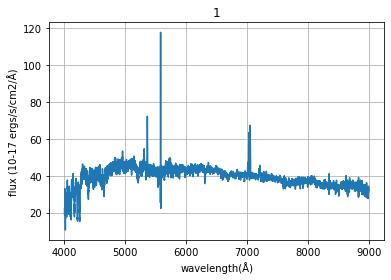

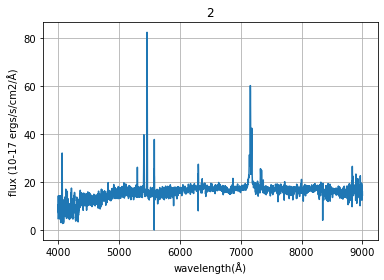

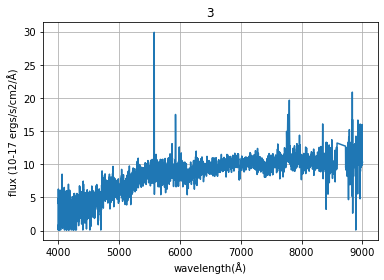

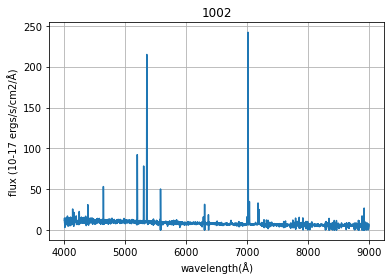

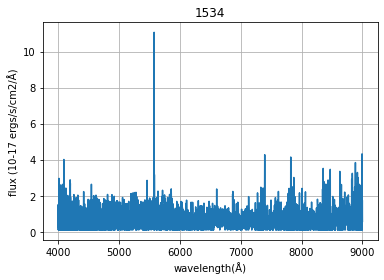

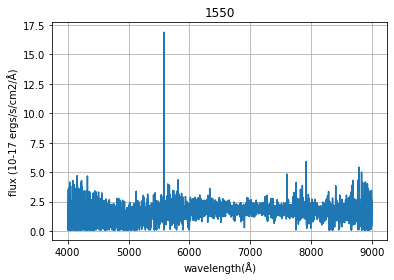

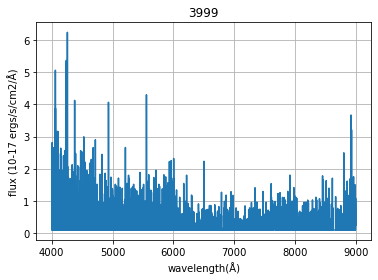

In [114]:
for i in [1, 2, 3, 1002, 1534, 1550, 3999]: #1534  
    plt.plot(wavelengths, data[i]) 
    plt.xlabel('wavelength(Å)') 
    plt.ylabel('flux (10-17 ergs/s/cm2/Å)') 
    plt.grid(True)
    plt.title(str(i))
    plt.show()

**Mit Normierung**

In [13]:
for i in [1,2,3,1002, 1534, 3999]:
    plt.plot(wavelengths, data_normalized[i]) 
    plt.xlabel('wavelength(Å)') 
    plt.ylabel('flux / median') 
    plt.grid(True)
    plt.title(str(i))
    plt.show()

NameError: name 'data_normalized' is not defined

## 3) Trainings- und Test-Datensatz erstellen

In [5]:
import random
# z = list(zip(data_normalized, labels)) # Mit Median-Normierung
z = list(zip(data, labels, numbers)) # Ohne Median-Normierung
random.shuffle(z)
data_shuffled, labels_shuffled, numbers_shuffled = zip(*z)

In [6]:
print(np.array(data_shuffled).shape)
print(np.array(labels_shuffled).shape)

(4000, 3522)
(4000,)


In [7]:
split_index = int(len(data_shuffled)*0.9)

# Daten
data_training = np.asarray(data_shuffled[:split_index])
data_test = np.asarray(data_shuffled[split_index:])

# Labels
labels_training = np.asarray(labels_shuffled[:split_index])
labels_test = np.asarray(labels_shuffled[split_index:])

# Galaxie numbers
numbers_training = numbers_shuffled[:split_index]
numbers_test = numbers_shuffled[split_index:]

## 4) Netzwerk erstellen

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv1D, MaxPooling1D, Dropout, InputLayer, GlobalAveragePooling1D
from tensorflow.keras.metrics import Accuracy

from tensorflow import keras
from tensorflow.keras import layers

In [9]:
input_shape = (3522,1)

data_training_r = np.reshape(data_training, newshape=(len(data_training), input_shape[0], input_shape[1]))
data_test_r  = np.reshape(data_test, newshape=(len(data_test), input_shape[0], input_shape[1]))

In [10]:
print(data_training_r.shape)
print(data_test_r.shape)

(3600, 3522, 1)
(400, 3522, 1)


In [11]:
# Conv1D, maxPool1D, categorical_crossentropy
# model = Sequential([
#     #Conv1D(filters=30, kernel_size=10, activation='relu', input_shape=(3522,1)),
#     Conv1D(filters=64, kernel_size=5, activation='relu'), #mehr Filtern
#     MaxPooling1D(4), # Größere Region
#     Dropout(0.1),
#     #Conv1D(filters=60, kernel_size=10, activation='relu'),
#     Conv1D(filters=64, kernel_size=5, activation='relu'),
#     MaxPooling1D(4),
#     # GlobalAveragePooling1D(),
#     Dropout(0.1),
#     Flatten(),
    
#     Dense(units=64, activation='relu'),
#     #Extra Dense
    
#     Dense(units=4, activation='softmax')
# ])

# Am besten (schnell):
model = Sequential([
    Conv1D(filters=64, kernel_size=80, strides=10, activation='relu', input_shape=(3522,1)), # stride
    MaxPooling1D(3), #Pooling verringert Accuracy leicht aber verhindert overfitting
    Dropout(0.35),
    Conv1D(filters=128, kernel_size=40, strides=10, activation='relu'),
    MaxPooling1D(3),
    Dropout(0.35),
    Flatten(),
    Dense(units=128, activation='relu'), # Droput, weniger neuronen
    Dropout(0.35),
    Dense(units=4, activation='softmax')
])

# model = Sequential([
#     Conv1D(filters=64, kernel_size=40, strides=10, activation='relu', input_shape=(3522,1)), # stride
#     Dropout(0.2),
#     Conv1D(filters=128, kernel_size=20, strides=5, activation='relu'), # stride
#     Dropout(0.2),
#     Flatten(),
#     Dense(units=4, activation='softmax')
# ])

# Langsamer, aber auch gut (aus paper):
# model = Sequential([
#     Conv1D(filters=16, kernel_size=21, activation='relu', input_shape=(3522,1)),
#     MaxPooling1D(2),
#     Conv1D(filters=32, kernel_size=11, activation='relu'),
#     MaxPooling1D(2),
#     Conv1D(filters=64, kernel_size=5, activation='relu'),
#     MaxPooling1D(2),    
#     Flatten(),
#     Dense(units=64, activation='relu'),
#     Dropout(0.5),
#     Dense(units=4, activation='softmax')
# ])

In [12]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# x_train = data_training_r
# x_test = data_test_r

x_train = tf.keras.utils.normalize(data_training_r, axis=1)
x_test = tf.keras.utils.normalize(data_test_r, axis=1)

y_train = labels_training
y_test = labels_test

In [14]:
history = model.fit(x_train, y_train,
                    epochs=75, validation_split=0.1,
                    shuffle=True, batch_size=200,
                    verbose=1)

# model_handler=Model.Model(shape=(height_dim,height_dim,lc_dim,1))


#model3 = tf.keras.models.load_model('spectral_classifier_v2.h5')
# model.save('spectral_classifier_v2.h5')

Epoch 1/75
17/17 [==============================] - 1s 63ms/step - loss: 1.3452 - accuracy: 0.3756 - val_loss: 1.2381 - val_accuracy: 0.4694
Epoch 2/75
17/17 [==============================] - 1s 58ms/step - loss: 1.1490 - accuracy: 0.4910 - val_loss: 1.0806 - val_accuracy: 0.4417
Epoch 3/75
17/17 [==============================] - 1s 57ms/step - loss: 1.0436 - accuracy: 0.5176 - val_loss: 1.0260 - val_accuracy: 0.5111
Epoch 4/75
17/17 [==============================] - 1s 57ms/step - loss: 1.0041 - accuracy: 0.5448 - val_loss: 0.9995 - val_accuracy: 0.5361
Epoch 5/75
17/17 [==============================] - 1s 57ms/step - loss: 0.9769 - accuracy: 0.5636 - val_loss: 0.9867 - val_accuracy: 0.5389
Epoch 6/75
17/17 [==============================] - 1s 57ms/step - loss: 0.9497 - accuracy: 0.5778 - val_loss: 0.9706 - val_accuracy: 0.5694
Epoch 7/75
17/17 [==============================] - 1s 58ms/step - loss: 0.9272 - accuracy: 0.5747 - val_loss: 0.9427 - val_accuracy: 0.5778
Epoch 8/75
17

Epoch 59/75
17/17 [==============================] - 1s 63ms/step - loss: 0.4807 - accuracy: 0.7892 - val_loss: 0.5247 - val_accuracy: 0.7972
Epoch 60/75
17/17 [==============================] - 1s 58ms/step - loss: 0.4643 - accuracy: 0.8022 - val_loss: 0.5416 - val_accuracy: 0.7778
Epoch 61/75
17/17 [==============================] - 1s 59ms/step - loss: 0.4807 - accuracy: 0.7951 - val_loss: 0.5386 - val_accuracy: 0.7917
Epoch 62/75
17/17 [==============================] - 1s 58ms/step - loss: 0.4663 - accuracy: 0.7957 - val_loss: 0.5324 - val_accuracy: 0.8056
Epoch 63/75
17/17 [==============================] - 1s 59ms/step - loss: 0.4765 - accuracy: 0.7904 - val_loss: 0.5407 - val_accuracy: 0.8000
Epoch 64/75
17/17 [==============================] - 1s 58ms/step - loss: 0.4748 - accuracy: 0.7920 - val_loss: 0.5181 - val_accuracy: 0.7944
Epoch 65/75
17/17 [==============================] - 1s 59ms/step - loss: 0.4726 - accuracy: 0.7935 - val_loss: 0.5210 - val_accuracy: 0.7917
Epoch 

## 5) Auswertungen

In [15]:
def plot_accuracy(name, ylim=[0,1.01]):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim(ylim[0], ylim[1])
    plt.legend(['training', 'validation'], loc='upper left')
    plt.savefig(name)
    plt.show()

In [16]:
def plot_loss(name, ylim=[-0.5,2]):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(ylim[0],ylim[1])
    plt.legend(['training', 'validation'], loc='upper left')
    plt.savefig(name)
    plt.show()


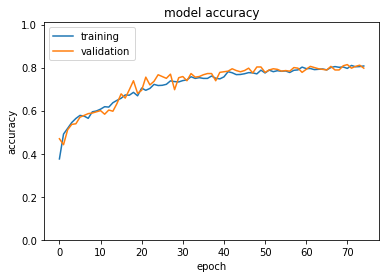

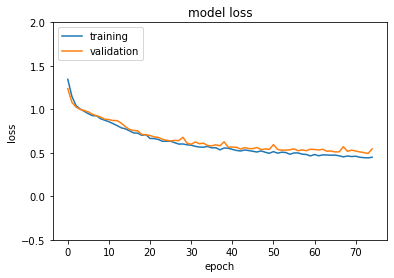

In [18]:
plot_accuracy("accuracy_graph.png")
plot_loss("loss_graph.png")

In [19]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(x=x_test)
rounded_predictions = np.argmax(predictions, axis=-1)

cm_labels = range(4)
cm = confusion_matrix(y_true=y_test, y_pred=rounded_predictions)

tf.math.confusion_matrix(
    labels=y_test, predictions=rounded_predictions, num_classes=4, weights=None, dtype=tf.dtypes.int32,
    name=None)

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[87,  4,  3,  1],
       [38, 74,  4,  4],
       [ 4,  5, 63, 15],
       [ 0,  1, 16, 81]])>

## Untersuchung der falsch klassifizierten Spektren

**Label 0 = AGN** \
**Label 1 = galaxy** \
**Label 2 = QSO** \
**Label 3 = star**

In [20]:
predictions = model.predict(x=x_test)
rounded_predictions = np.argmax(predictions, axis=-1)

wrong_predictions = []

for i in range(len(rounded_predictions)):
    if rounded_predictions[i] != y_test[i]:
        wrong_predictions.append(numbers_test[i])      

wrong_predictions.sort()
        
print(len(rounded_predictions), "richtig")
print(len(wrong_predictions), "falsch")
print(str(((len(rounded_predictions)-len(wrong_predictions))/len(rounded_predictions))*100) + "% richtig klassifiziert")

400 richtig
95 falsch
76.25% richtig klassifiziert


In [21]:
print(wrong_predictions)

[235, 264, 322, 459, 579, 730, 822, 968, 1003, 1029, 1038, 1048, 1058, 1066, 1134, 1139, 1180, 1249, 1267, 1277, 1316, 1331, 1339, 1357, 1374, 1380, 1393, 1488, 1493, 1494, 1504, 1509, 1516, 1544, 1556, 1591, 1621, 1642, 1657, 1687, 1733, 1738, 1762, 1766, 1774, 1776, 1820, 1825, 1838, 1841, 1856, 1864, 1916, 1953, 2028, 2077, 2207, 2208, 2274, 2371, 2426, 2467, 2559, 2567, 2616, 2667, 2679, 2687, 2754, 2765, 2799, 2830, 2840, 2880, 2907, 2940, 2965, 2986, 3021, 3035, 3044, 3064, 3106, 3219, 3233, 3303, 3348, 3375, 3401, 3462, 3465, 3527, 3568, 3681, 3937]


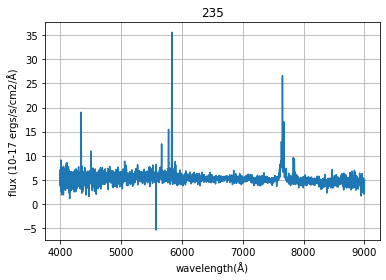

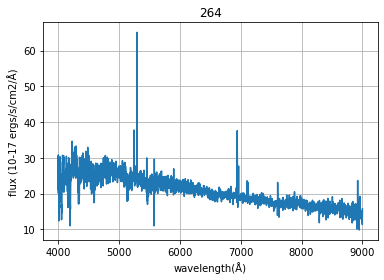

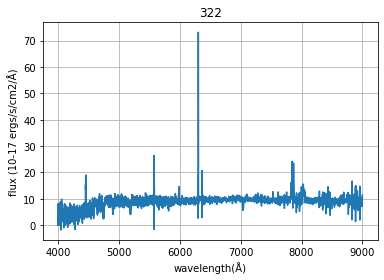

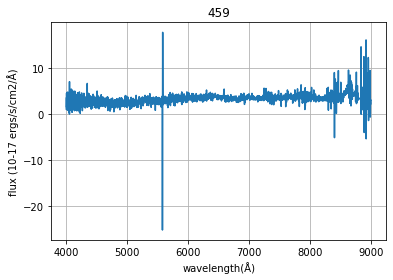

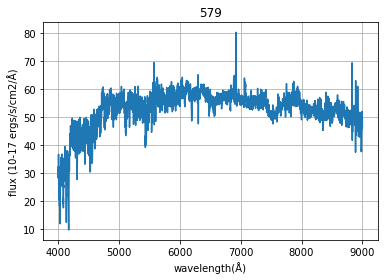

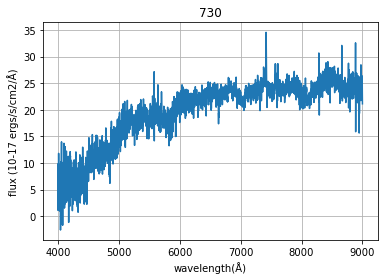

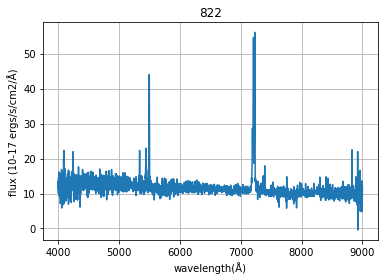

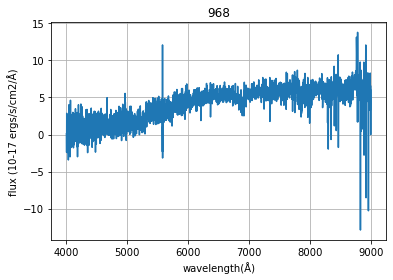

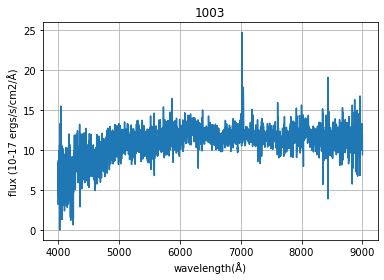

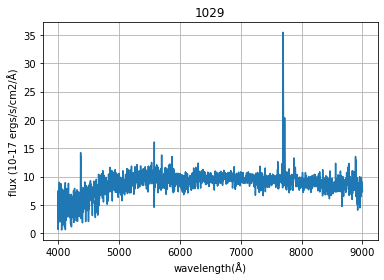

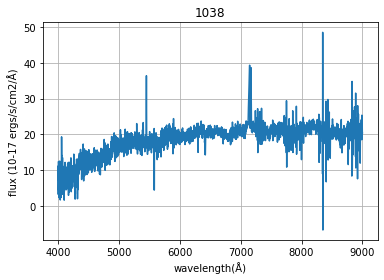

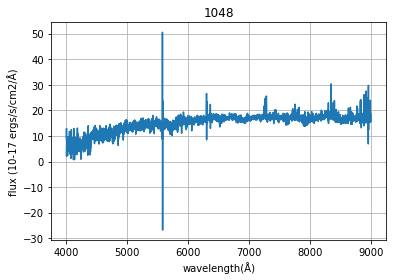

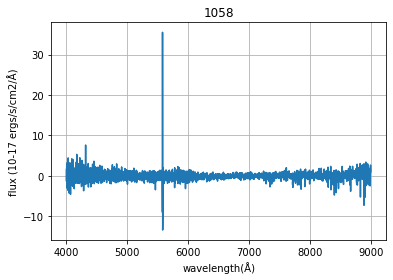

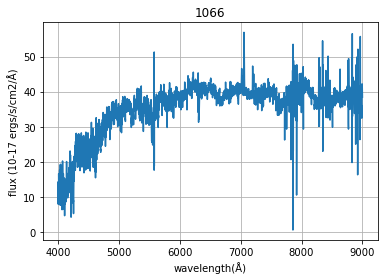

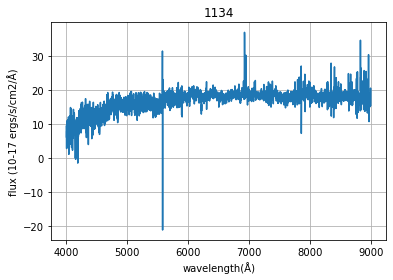

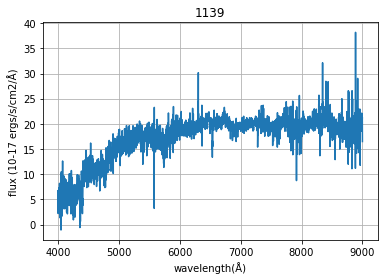

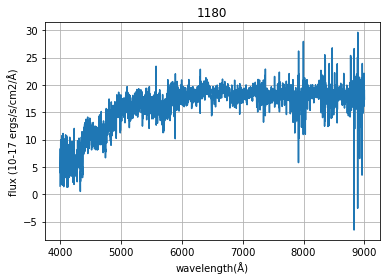

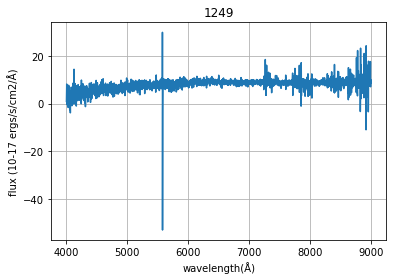

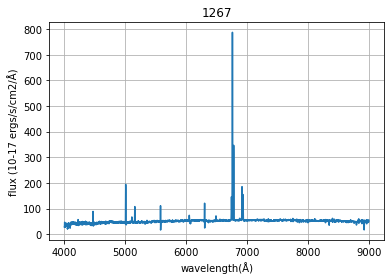

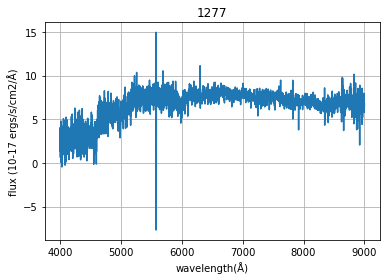

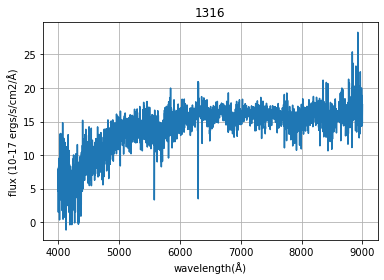

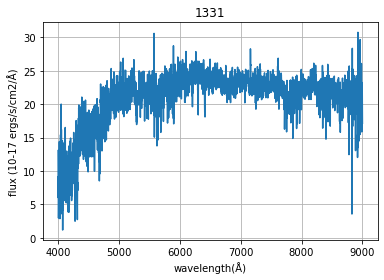

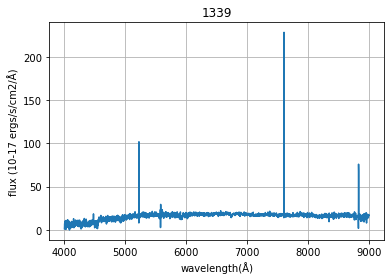

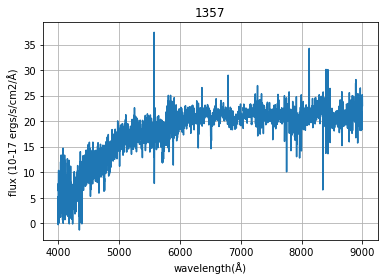

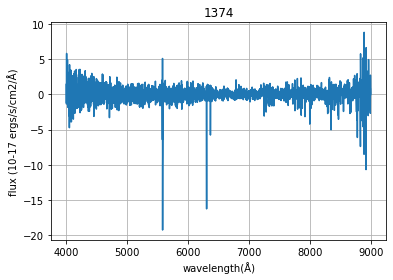

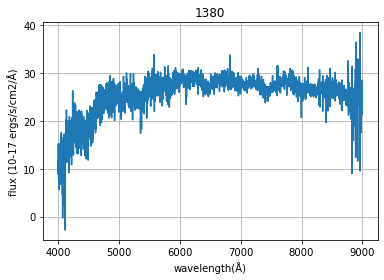

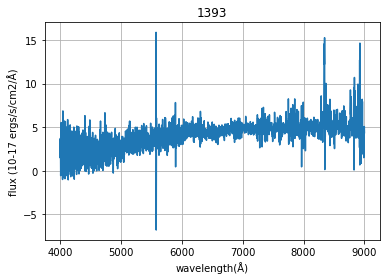

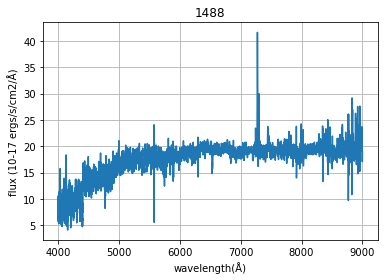

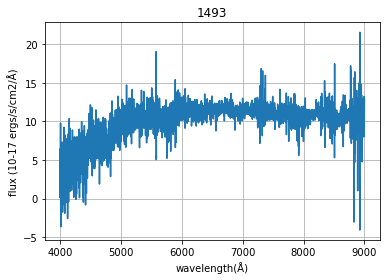

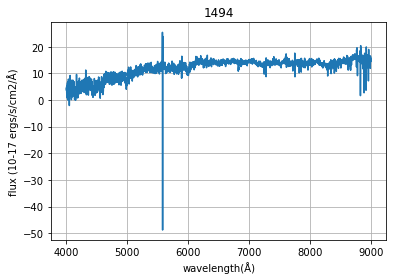

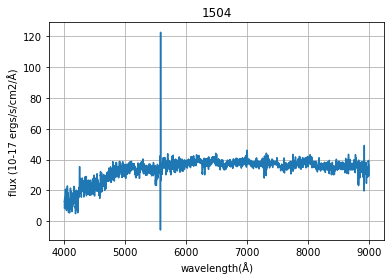

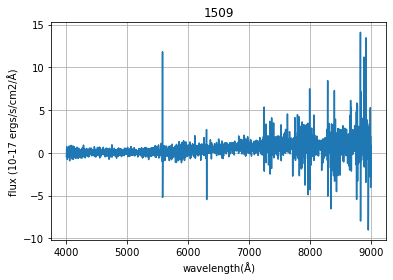

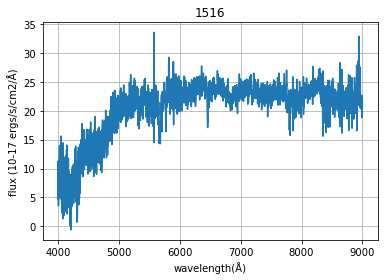

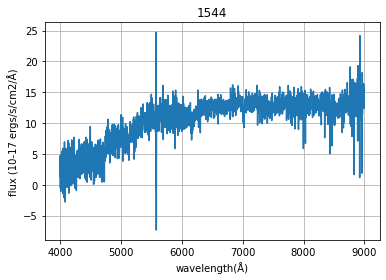

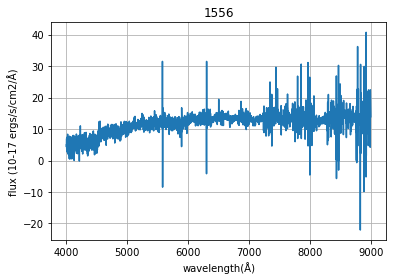

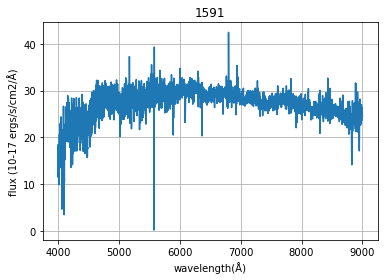

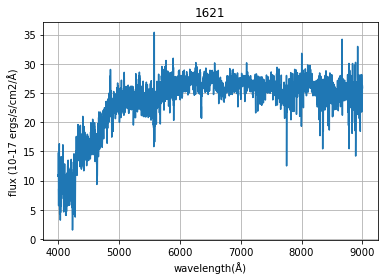

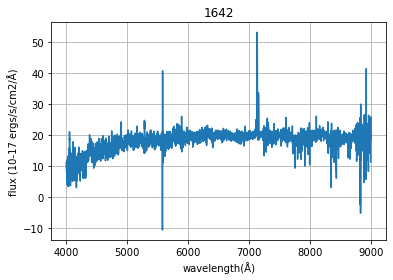

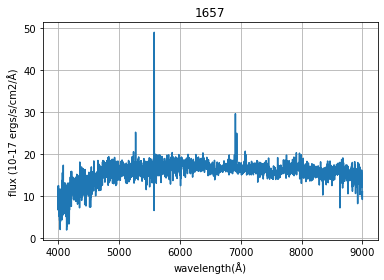

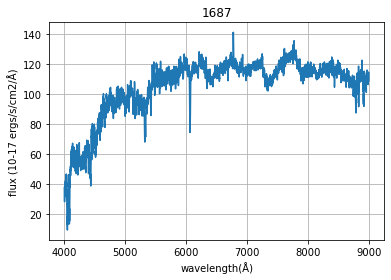

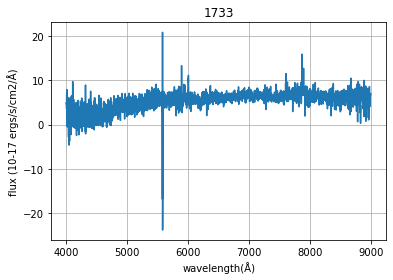

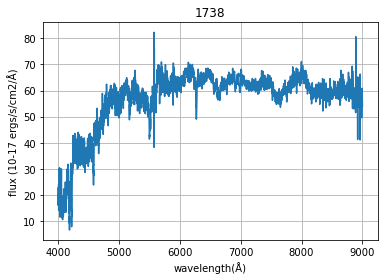

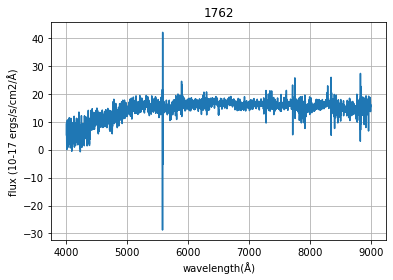

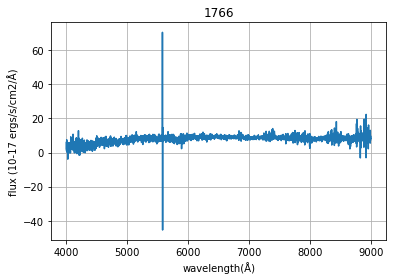

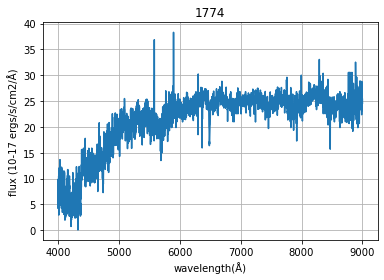

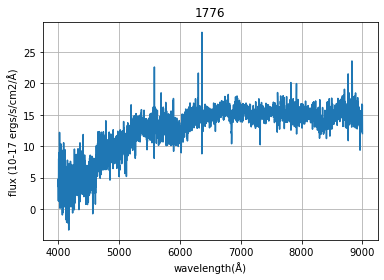

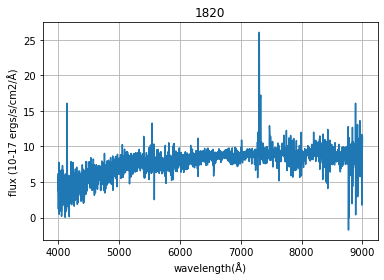

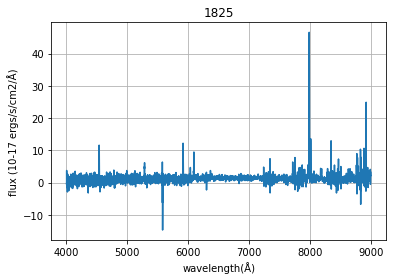

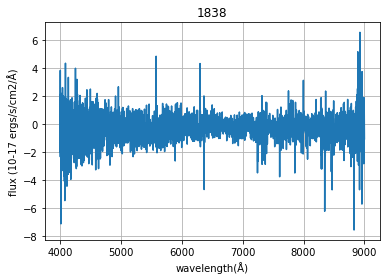

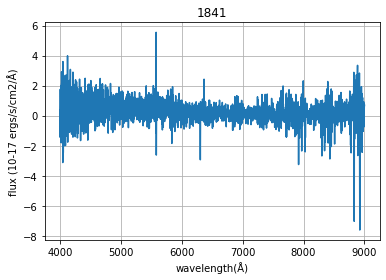

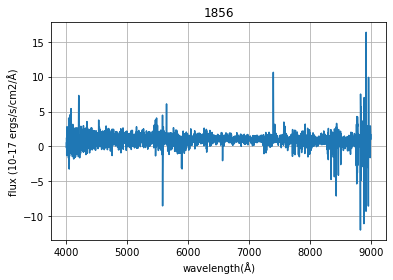

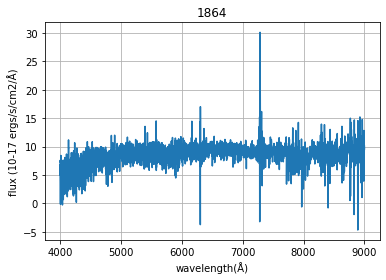

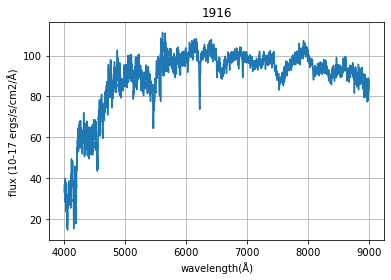

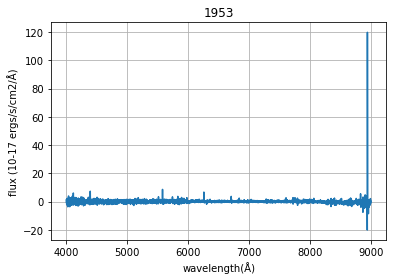

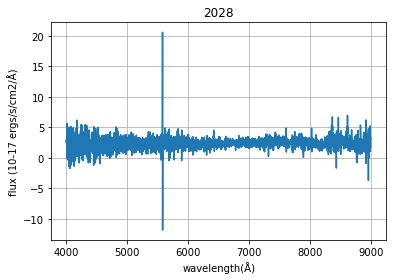

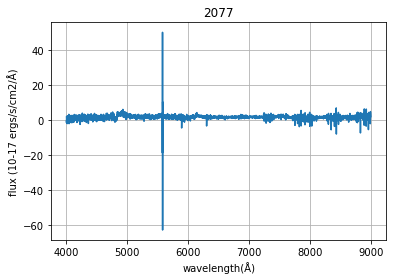

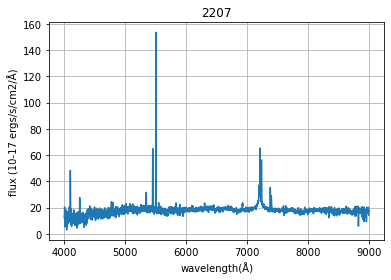

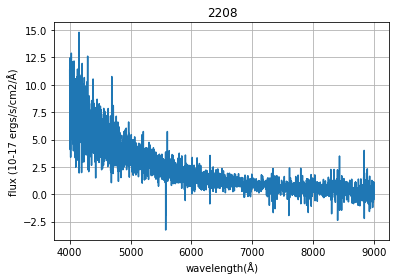

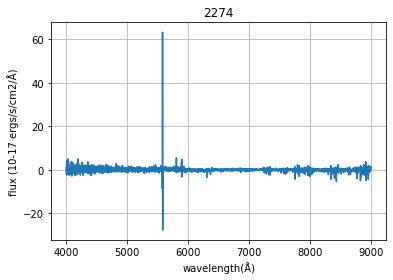

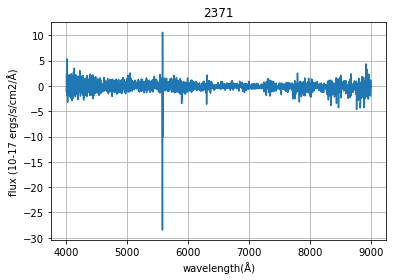

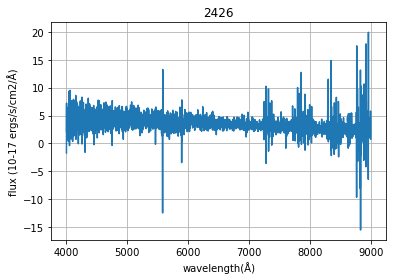

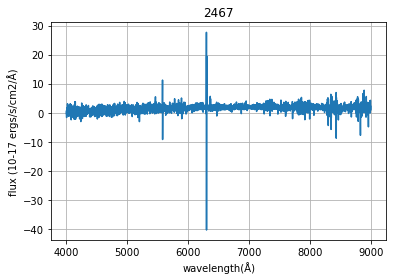

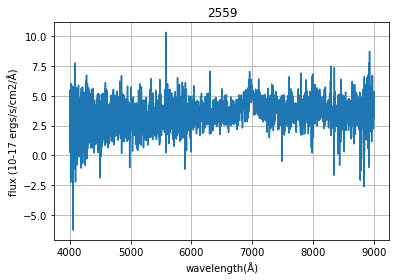

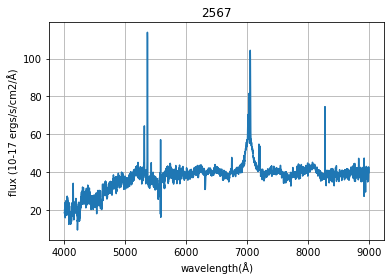

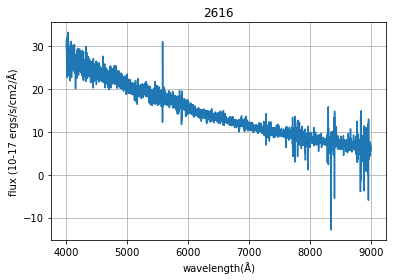

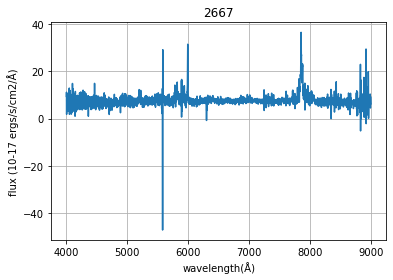

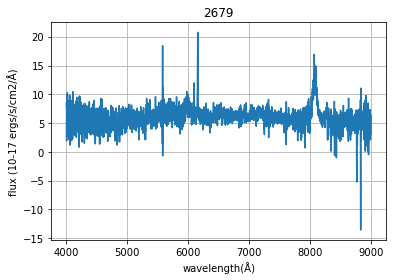

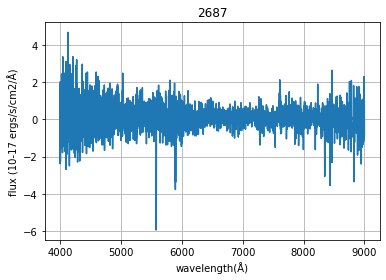

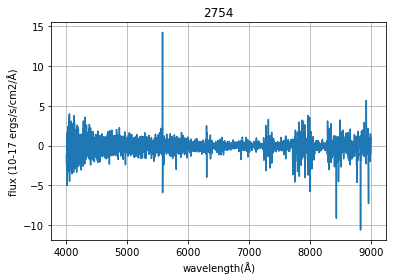

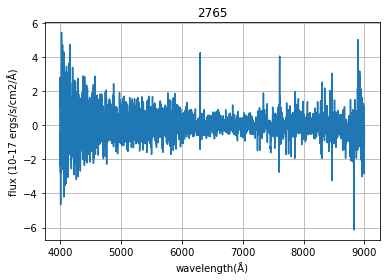

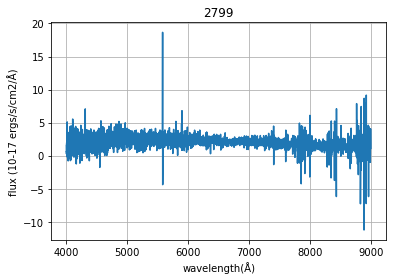

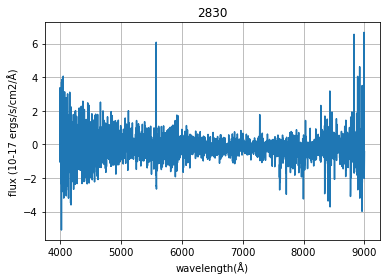

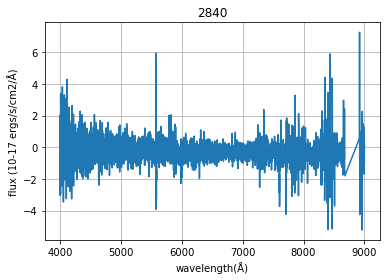

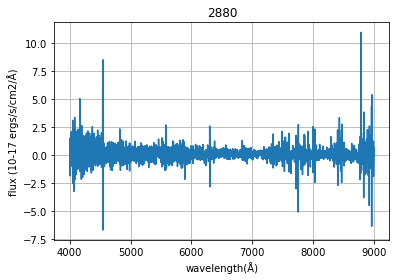

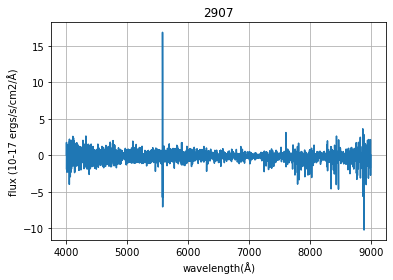

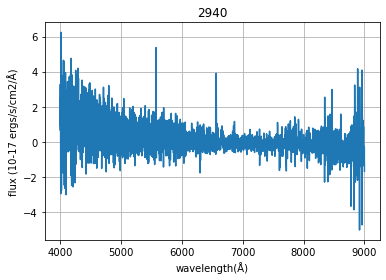

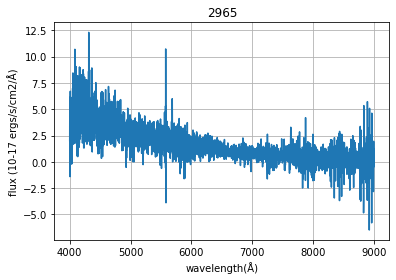

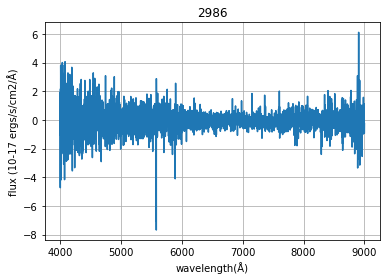

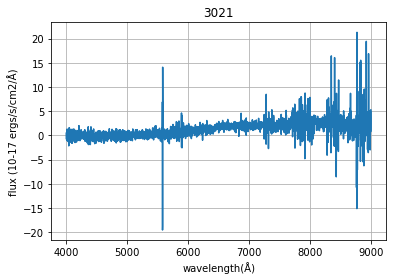

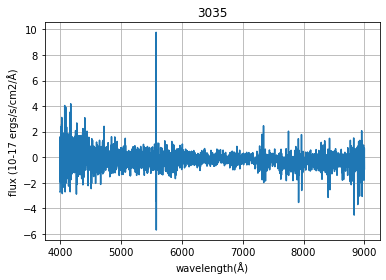

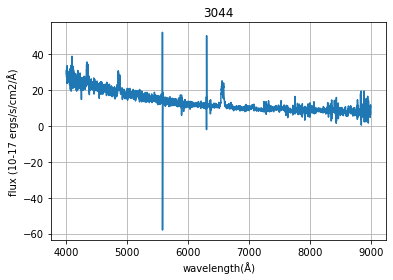

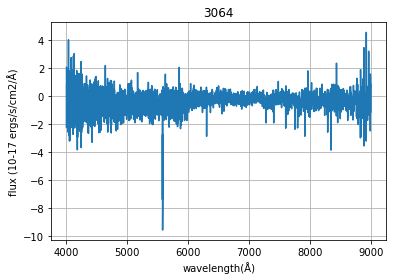

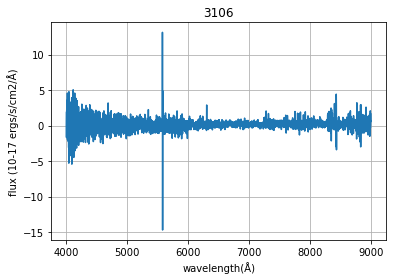

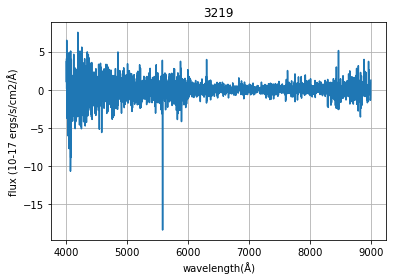

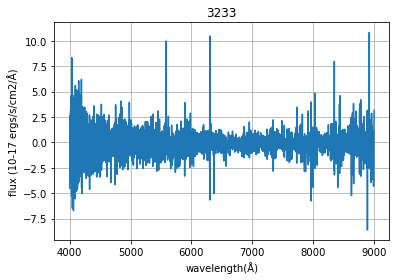

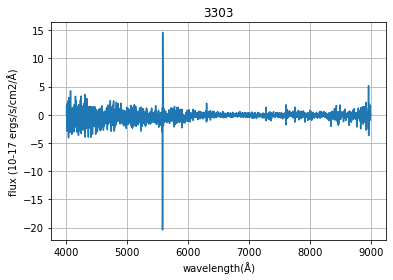

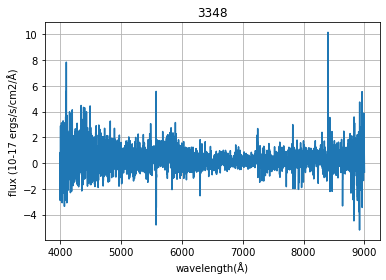

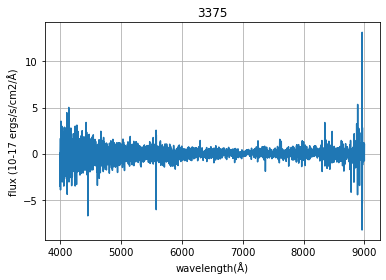

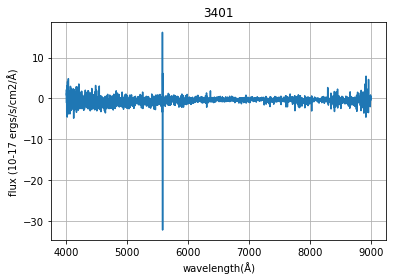

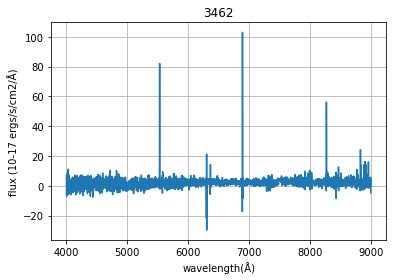

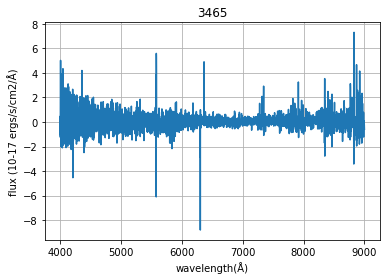

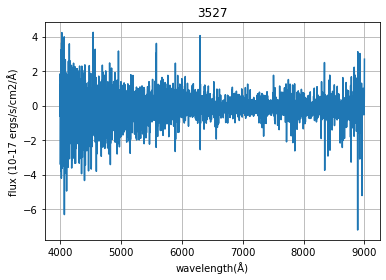

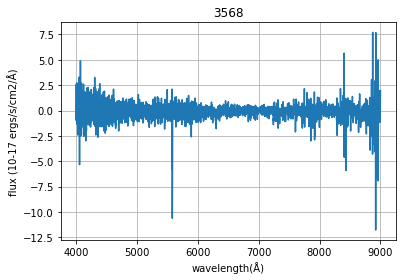

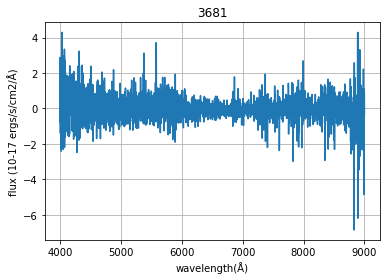

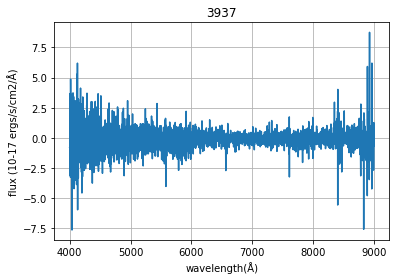

In [22]:
for i in wrong_predictions:  
    plt.plot(wavelengths, data[i]) 
    plt.xlabel('wavelength(Å)') 
    plt.ylabel('flux (10-17 ergs/s/cm2/Å)') 
    plt.grid(True)
    plt.title(str(i))
    plt.show()

## Vergleichs-Benchmark

In [124]:
from sklearn import svm
clf = svm.SVC(gamma=0.001, C=100.)
clf.fit(data_training, labels_training)
clf.score(data_test, labels_test)

0.28

In [296]:
from sklearn.linear_model import LogisticRegression
clf1 = LogisticRegression(max_iter=1000, random_state=123)
clf1.fit(data_training, labels_training)
clf1.score(data_test, labels_test)

C:\Users\Josh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6775

In [299]:
from sklearn.ensemble import RandomForestClassifier
clf2 = RandomForestClassifier(n_estimators=100, random_state=123)
clf2.fit(data_training, labels_training)
clf2.score(data_test, labels_test)

0.7225

In [297]:
from sklearn.naive_bayes import GaussianNB
clf3 = GaussianNB()
clf3.fit(data_training, labels_training)
clf3.score(data_test, labels_test)

0.4225